In [1]:
import pandas as pd
import numpy as np

In [2]:
L='nktr aig amd luv pch wdc nclh celg dwdp spxc ame xyl stt r akam reg dov xray chd apc'.upper().split(' ')

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [3]:
df=pd.read_csv('11011116_vwap.csv',header=0)


C:\Users\DR\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df_t=df[df['SYM_ROOT']==L[6]]
df_t.head(5)

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
921558,20181101,9:30:00.705640000,N,NCLH,NaN,O,26001,44.56,0,1750201,C,NaN
921559,20181101,9:30:00.739536000,T,NCLH,NaN,O X,900,44.89,0,1756001,C,NaN
921560,20181101,9:30:00.739567000,T,NCLH,NaN,Q,900,44.89,0,1756101,C,NaN
921561,20181101,9:30:02.020829000,P,NCLH,NaN,F I,2,44.62,0,1804801,C,NaN
921562,20181101,9:30:02.020849000,P,NCLH,NaN,Q,2,44.62,0,1804901,C,NaN


In [13]:
D=list(set(df_t['DATE']))

In [14]:

St=[]
for d in D[:-1]:
    s=[]
    i=-1
    T=[]
    df_d=df_t[df_t['DATE']==d]
    for j in range(len(df_d['TIME_M'])):
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            i+=1
            T.append(np.array(df_d['TIME_M'])[j][:-13])
           
            s.append(np.array(df_d['SIZE'])[j])
        else:
            s[i]+=np.array(df_d['SIZE'])[j]
    if len(s)==30:
        St.append(s)
    #print(T)

In [15]:
St=np.array(St,dtype=float)

In [16]:
for i in range(len(St)):
    St[i,:]=St[i,:]/float(np.sum(St[i,:]))

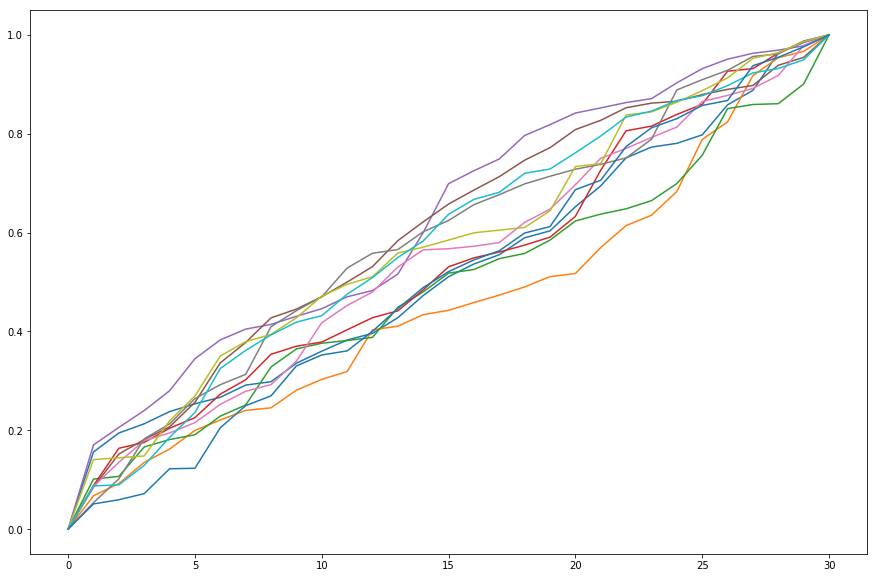

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_cumper(St):
    plt.figure(figsize=(15,10))
    for i in range(len(St)):
        c=[0]+[np.sum(St[i,:j+1]) for j in range(len(St[i]))]
        plt.plot(c)
plot_cumper(St)

In [18]:
vol_mean=np.mean(St,axis=0)
vol_mean

array([0.09880112, 0.03250775, 0.03425605, 0.03495583, 0.03392391,
       0.05040269, 0.02873854, 0.03419376, 0.03269184, 0.02649819,
       0.02647288, 0.02896682, 0.03566592, 0.03840828, 0.03565433,
       0.02065312, 0.0167438 , 0.02716286, 0.02024776, 0.04151218,
       0.03217037, 0.04233251, 0.01834506, 0.03000674, 0.03405906,
       0.03410561, 0.03040029, 0.02365758, 0.02460756, 0.03185759])

In [19]:
df_d=df_t[df_t['DATE']==D[0]]
T=[]
s_start=[]
p_start=[]
i=-1
for j in range(len(df_d['TIME_M'])):
    if np.array(df_d['TIME_M'])[j][:-13] not in T:
        i+=1
        T.append(np.array(df_d['TIME_M'])[j][:-13])
        p_start.append(np.array(df_d['PRICE'])[j])
        s_start.append(np.array(df_d['SIZE'])[j])
    else:
        s_start[i]+=np.array(df_d['SIZE'])[j]

In [20]:
df_d=df_t[df_t['DATE']==D[-1]]
T=[]
s_end=[]
p_end=[]
i=-1
for j in range(len(df_d['TIME_M'])):
    if np.array(df_d['TIME_M'])[j][:-13] not in T:
        i+=1
        T.append(np.array(df_d['TIME_M'])[j][:-13])
        p_end.append(np.array(df_d['PRICE'])[j])
        s_end.append(np.array(df_d['SIZE'])[j])
    else:
        s_end[i]+=np.array(df_d['SIZE'])[j]

In [21]:
s_per=np.array(s)/float(sum(s))

In [22]:
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    size_=size
    history=[]
    while size>0:
        goal=target_percentage[i]*size_
        if i==len(target_percentage)-1:
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))
def benchmark(size,real_volume,real_price):
    history=np.array(real_volume)*size/float(sum(real_volume))
    VWAP=np.sum(history*np.array(real_price))
    return history,VWAP/float(np.sum(history))


In [23]:
Dict_=np.load('data.npy').item()

In [24]:
p_d=np.array(Dict_['aig']['Open'])[23]
cap=100000
size=int(cap/p_d)
h,r,pb=execution(vol_mean,size,s_start,p_start)

In [25]:
size=int(cap/p_d)
h,r,ps=execution(vol_mean,size,s_end,p_end)

In [26]:
benchmark(size,s_start,p_start)

(array([386.16063592,  95.00488659,  46.31062572,  60.89424569,
         39.03055778,  32.68985345,  61.01166614,  17.02596534,
         92.59776735,  60.38933775,  55.57509927,  33.74663751,
         78.26073033, 110.91535765,  94.35907411,  63.78278877,
         46.36933595,  84.75408125,  34.72122725, 120.82564368,
        104.44549082, 140.58750552,  53.62591979,  18.86946641,
         42.43575085, 150.43908132,  72.47190212, 186.88638919,
         52.93313913,  37.87983737]), 44.806050687680575)

In [27]:
benchmark(size,s_end,p_end)

(array([7.81802167e+02, 3.39294405e-01, 1.09083151e+01, 1.41451837e+02,
        7.02339418e+01, 1.29898863e+02, 9.22371839e+01, 1.94144258e+02,
        7.88859491e+00, 5.47790816e+01, 4.06983638e+01, 2.17657361e+01,
        1.32138206e+02, 1.72531205e+01, 3.73054198e+01, 6.70445744e+01,
        2.12228650e+01, 2.15451947e+01, 4.08849758e+01, 1.00838297e+02,
        3.23856509e+01, 5.95292033e+01, 2.05273115e+00, 6.03774393e+01,
        2.97561193e+01, 1.22298668e+02, 8.16003043e+00, 4.80949819e+01,
        1.73379441e+01, 1.10626941e+02]), 50.566419441226664)

In [28]:
(size*ps-size*pb)/(size*pb)

0.13290305417180326

In [29]:
pb,ps

(44.7773471249491, 50.728393315565846)